<a href="https://colab.research.google.com/github/tsengcc2023/Financial-Big-Data-Analysis/blob/main/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

延用上週爬取的股價資料，完成本次作業要求：
1. 計算技術指標（SMA、RSI、MACD）
2. 可視化 K 線圖
3. 技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價

# 爬取股價資料

In [15]:
pip install yfinance

In [16]:
pip install wget

[*********************100%***********************]  1 of 1 completed


股票數據前5筆：
        Date   Open   High    Low  Close   Adj Close    Volume
0 2023-01-03  446.0  453.5  443.0  453.0  437.941528  14885824
1 2023-01-04  449.5  455.0  448.5  449.5  434.557892  19188422
2 2023-01-05  459.0  459.5  455.0  458.5  443.258698  23549581
3 2023-01-06  455.0  459.5  455.0  458.5  443.258698  20886011
4 2023-01-09  468.0  481.0  467.5  481.0  465.010773  46666263


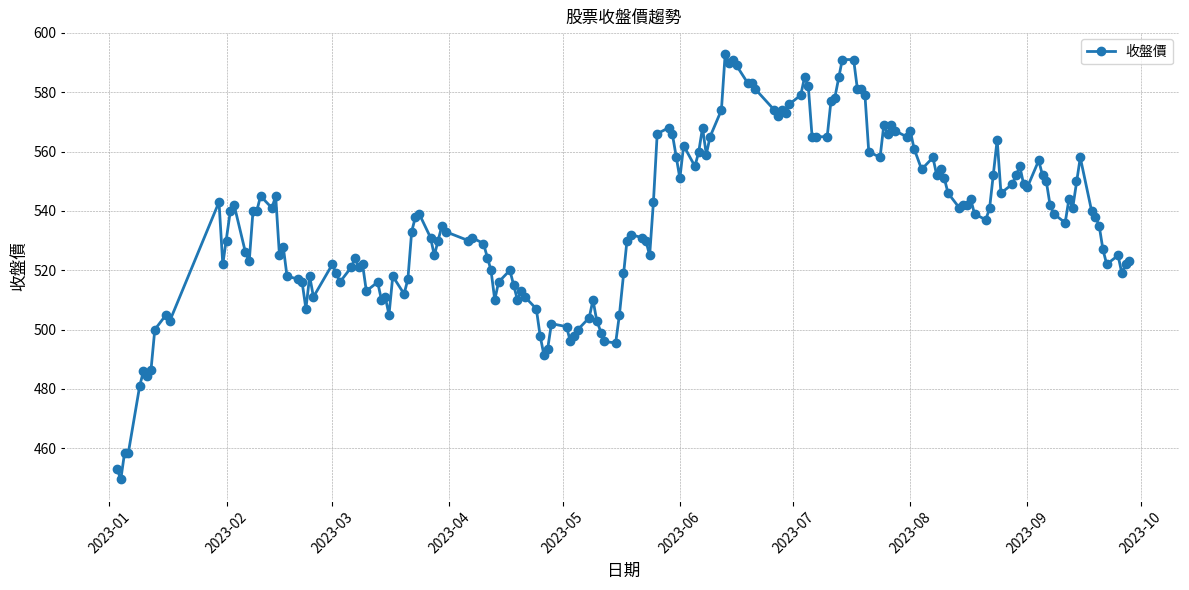

In [17]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager
import wget

# 下載中文字體
wget.download("https://github.com/GrandmaCan/ML/raw/main/Resgression/ChineseFont.ttf")

# 將下載的中文字體引入到 matplotlib 的字體管理
fontManager.addfont("ChineseFont.ttf")
mpl.rc('font', family="ChineseFont")  # 設定 matplotlib 使用此字體

# 定義函數來抓取股價數據並轉換為 DataFrame
def fetch_stock_data(stock_id, start_date, end_date):
    # 下載股票數據
    stock = yf.download(stock_id, start=start_date, end=end_date)

    # 重設索引並轉換為 DataFrame 格式
    df = stock.reset_index()
    print("股票數據前5筆：")
    print(df.head())

    return df

# 可視化股價趨勢的函數
def visualize_stock_data(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], marker='o', label='收盤價')
    plt.title('股票收盤價趨勢')
    plt.xlabel('日期')
    plt.ylabel('收盤價')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 主程式
if __name__ == "__main__":
    # 設定股票代號
    stock_id = '2330.TW'

    # 設定日期範圍
    start_date = '2023-01-01'
    end_date = '2023-09-29'

    # 抓取股票數據並轉換為 DataFrame
    df = fetch_stock_data(stock_id, start_date, end_date)

    # 可視化股價數據
    visualize_stock_data(df)

In [18]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,446.0,453.5,443.0,453.0,437.941528,14885824
1,2023-01-04,449.5,455.0,448.5,449.5,434.557892,19188422
2,2023-01-05,459.0,459.5,455.0,458.5,443.258698,23549581
3,2023-01-06,455.0,459.5,455.0,458.5,443.258698,20886011
4,2023-01-09,468.0,481.0,467.5,481.0,465.010773,46666263
...,...,...,...,...,...,...,...
171,2023-09-22,523.0,525.0,522.0,522.0,512.596497,29049309
172,2023-09-25,522.0,529.0,522.0,525.0,515.542480,17116402
173,2023-09-26,521.0,524.0,519.0,519.0,509.650513,26392692
174,2023-09-27,517.0,523.0,516.0,522.0,512.596497,16846401


# 1️⃣ 計算技術指標（SMA、RSI、MACD）

## SMA

In [19]:
import pandas as pd

# 計算簡單移動平均線（SMA）
def calculate_sma(df, period):
    df[f'SMA_{period}'] = df['Close'].rolling(window=period).mean()
    return df

## RSI

In [20]:
# 計算相對強弱指標（RSI）
def calculate_rsi(df, period=14):
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

## MACD

In [21]:
# 計算MACD
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    df['EMA_12'] = df['Close'].ewm(span=short_period, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=long_period, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
    return df

# 2️⃣ 可視化 K 線圖

In [22]:
pip install mplfinance

[*********************100%***********************]  1 of 1 completed


股票數據前5筆：
        Date   Open   High    Low  Close   Adj Close    Volume
0 2023-01-03  446.0  453.5  443.0  453.0  437.941528  14885824
1 2023-01-04  449.5  455.0  448.5  449.5  434.557892  19188422
2 2023-01-05  459.0  459.5  455.0  458.5  443.258698  23549581
3 2023-01-06  455.0  459.5  455.0  458.5  443.258698  20886011
4 2023-01-09  468.0  481.0  467.5  481.0  465.010773  46666263


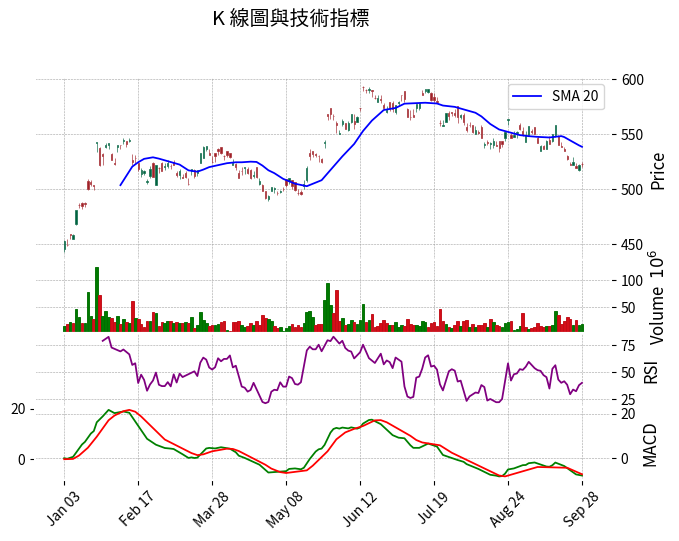

In [25]:
import mplfinance as mpf

# 可視化 K 線圖並疊加技術指標
def visualize_candlestick(df):
    # 定義K線圖樣式
    mpf_style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.family': 'ChineseFont'})

    # 重新設定日期為索引，讓 mplfinance 可以使用
    df.set_index('Date', inplace=True)

    # 使用 mplfinance 可視化 K 線圖與技術指標
    mpf.plot(df, type='candle', volume=True, style=mpf_style,
             title='K 線圖與技術指標',
             addplot=[
                 mpf.make_addplot(df['SMA_20'], color='blue', label='SMA 20'),
                 mpf.make_addplot(df['RSI'], panel=2, color='purple', ylabel='RSI'),
                 mpf.make_addplot(df['MACD'], panel=3, color='green', ylabel='MACD'),
                 mpf.make_addplot(df['Signal_Line'], panel=3, color='red')
             ])

if __name__ == "__main__":
    stock_id = '2330.TW'
    start_date = '2023-01-01'
    end_date = '2023-09-29'

    # 抓取股票數據並計算技術指標
    df = fetch_stock_data(stock_id, start_date, end_date)
    df = calculate_sma(df, 20)
    df = calculate_rsi(df)
    df = calculate_macd(df)

    # 可視化 K 線圖與技術指標
    visualize_candlestick(df)

# 3️⃣ 技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 創建目標變數：用來預測第 n 天的股價變動方向
def create_target(df, n=1):
    df['Target'] = df['Close'].shift(-n) > df['Close']
    df.dropna(inplace=True)  # 移除有 NaN 的行
    return df

# 分割特徵與目標
def prepare_data(df):
    features = df[['SMA_20', 'RSI', 'MACD', 'Signal_Line']]
    target = df['Target']
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# 使用不同模型進行預測
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    # 線性回歸
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test) > 0.5
    print(f"Linear Regression Accuracy: {accuracy_score(y_test, lr_pred)}")

    # 決策樹
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_test)
    print(f"Decision Tree Accuracy: {accuracy_score(y_test, dt_pred)}")

    # 隨機森林
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred)}")

# 主程式
if __name__ == "__main__":
    # 前面的步驟
    stock_id = '2330.TW'
    start_date = '2020-01-01'
    end_date = '2023-09-01'
    df = fetch_stock_data(stock_id, start_date, end_date)
    df = calculate_sma(df, 20)
    df = calculate_rsi(df)
    df = calculate_macd(df)

    # 準備資料並建立目標變數
    df = create_target(df)
    X_train, X_test, y_train, y_test = prepare_data(df)

    # 訓練並評估模型
    train_and_evaluate_model(X_train, X_test, y_train, y_test)

[*********************100%***********************]  1 of 1 completed


股票數據前5筆：
        Date   Open   High    Low  Close   Adj Close    Volume
0 2020-01-02  332.5  339.0  332.5  339.0  306.430206  31754120
1 2020-01-03  344.0  345.0  335.5  339.5  306.882172  41811268
2 2020-01-06  333.0  334.5  332.0  332.0  300.102692  45343057
3 2020-01-07  332.5  333.0  326.5  329.5  297.842865  50879181
4 2020-01-08  325.0  333.0  325.0  329.5  297.842865  37567748
Linear Regression Accuracy: 0.5428571428571428
Decision Tree Accuracy: 0.52
Random Forest Accuracy: 0.5257142857142857
